In [2]:
import requests
import bs4
import re
import pandas as pd
import json
import numpy as np
from bs4 import BeautifulSoup
file_path = 'data/'

# JSON 파일 불러오기
with open(file_path + 'PREFIX.json', 'r', encoding='utf-8') as f:
    PREFIX = json.load(f)
with open(file_path + 'SUFFIX.json', 'r', encoding='utf-8') as f:
    SUFFIX = json.load(f)


In [3]:

# 기존 구조: nested 딕셔너리 만들기
req_parameter_nested = {
    region: {
        district: PREFIX[region] + suffix[-3:]
        for district, suffix in districts.items()
    }
    for region, districts in SUFFIX.items()
}

# 평탄화(flatten) + 시단위 전체 지역 코드 추가
req_parameter = {}

for region, districts in req_parameter_nested.items():
    # 시 전체 ('서울') 코드: '강남구'처럼 직접 접근할 수 있도록
    if '전체' in districts:
        req_parameter[region] = districts['전체']  # ex) '서울': '101000'
    # 각 구/군도 추가
    for district, code in districts.items():
        req_parameter[district] = code

req_parameter2={
    '지역별':'domestic',
    '직업별':'job-category',
    '역세권별':'subway',
    'HOT100':'hot100',
    '헤드헌팅':'headhunting'
}


In [18]:
job_link_list = []
corp_link_list = []
logo_list = []
title_list =[]
job_list = []
corp_list = []
local_list = []
exp_list = []
grad_list = []
date_list = []
badge_list = []
upload_list = []
for page in range(1,2):
    url = "https://www.saramin.co.kr/zf_user/jobs/list/{지역별}?page={page}&loc_cd={서울}&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y".format(page=page, **req_parameter2, **req_parameter)
    print(url)
    req_header = {
        'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/135.0.0.0 Safari/537.36'
    }

    res = requests.get(url, headers = req_header)
    res.encoding = 'utf-8'

    
    if res.ok:
        html = res.text
        soup = BeautifulSoup(html, 'html.parser') 
        # CSS 선택자
        a_tag_list = soup.select("div#default_list_wrap div.list_body div.box_item")
        # <a> 태그 리스트 순회하기    
        for a_tag in a_tag_list:
            # 링크
            job_link_dict = {}
            if a_tag.find("div", class_ ="job_tit").find("a", class_ = "str_tit") == None:
                print(a_tag.find("div", class_ ="job_tit"))
                job_link_dict['링크'] = 'NULL'
            else:
                job_link_dict['링크'] = "https://www.saramin.co.kr" + a_tag.find("div", class_ ="job_tit").find("a", class_ = "str_tit")['href']
            job_link_list.append(job_link_dict)

            # 회사 링크
            corp_link_dict = {}
            if a_tag.find("div", class_ ="col company_nm").find("a", class_ = "str_tit") == None:
                corp_link_dict['회사링크'] = 'NULL'
            else:
                corp_link_dict['회사링크'] = "https://www.saramin.co.kr" + a_tag.find("div", class_ ="col company_nm").find("a", class_ = "str_tit")['href']
            corp_link_list.append(corp_link_dict)

            # 로고
            # logo_dict = {}
            # if len(a_tag.select("span.logo img[src*='banner_logo/company/logo_banner/']")) == 0:
            #     logo_dict['로고'] = 'Null'
            # else:
            #     img_url = a_tag.select("span.logo img[src*='banner_logo/company/logo_banner/']")
            #     logo_dict['로고'] = img_url[0]['src']
            # logo_list.append(logo_dict)

            # 제목
            title_dict = {}
            if len(a_tag.find("div", class_ ="col notification_info").find("div", class_ = "job_tit").select("span")) == 0:
                title_dict['제목'] = 'Null'
            else:
                title = a_tag.find("div", class_ ="col notification_info").find("div", class_ = "job_tit").select("span")[0].text
                title_dict['제목'] = title
            title_list.append(title_dict)

            # 회사
            corp_dict = {}
            if len(a_tag.find("div", class_ ="col company_nm").find(class_ = "str_tit")) == 0:
                corp_dict['회사'] = 'Null'
            else:
                corp = a_tag.find("div", class_ ="col company_nm").find(class_ = "str_tit").text
                corp_dict['회사'] = corp
            corp_list.append(corp_dict)
            clean_corp = []
            for item in corp_list:
                clean_item = {key: re.sub(r'\s+', ' ', value).strip() for key, value in item.items()}
                clean_corp.append(clean_item)
            
            # 직무
            job_dict = {}
            job = a_tag.select_one('.job_sector')
            if len(job) == 0:
                job_dict['직무'] = 'Null'
            else:
                jobs = [span.get_text(strip=True).replace('::before', '').strip() for span in job.find_all('span')]
                job_dict['직무'] = jobs
            job_list.append(job_dict)
            # 지역, 경력, 학력
            temp = a_tag.find("div", class_ = "col recruit_info")
            local_dict = {}
            exp_dict = {}
            grad_dict = {}
            if len(temp) >= 3:
                local_dict['지역'] = temp.find("p", class_ = "work_place").text
                exp_dict['요구경력'] = temp.find("p", class_ = "career").text
                grad_dict['최소학력'] = temp.find("p", class_ = "education").text
            else:
                local_dict['지역'] = 'NULL'
                exp_dict['요구경력'] = 'NULL'
                grad_dict['최소학력'] = 'NULL'
            local_list.append(local_dict)
            exp_list.append(exp_dict)
            grad_list.append(grad_dict)

            for region in local_list:
                if region['지역'].endswith(' 외'):
                    region['지역'] = region['지역'][:-2]

            # 기간
            date_dict = {}
            if len(a_tag.select("span.date")) == 0:
                date_dict['기간'] = 'Null'
            else:
                date = a_tag.select("span.date")[0].text
                date_dict['기간'] = date
            date_list.append(date_dict)

            clean_date = []
            for item in date_list:
                clean_item = {key: re.sub(r'\s+', ' ', value).strip() for key, value in item.items()}
                clean_date.append(clean_item)

            # 등록일자
            upload_dict = {}
            if len(a_tag.select_one("span.deadlines")) == 0:
                upload_dict['등록일자'] = 'Null'
            else:
                upload = a_tag.select("span.deadlines")[0].text
                upload_dict['등록일자'] = upload
            upload_list.append(upload_dict)

            # 배지
            badge_dict = {}
            if a_tag.select_one(".job_badge") == None:
                badge_dict['배지'] = 'Null'
            else:
                badge = a_tag.select_one(".job_badge").find("span").text
                badge_dict['배지'] = badge
            badge_list.append(badge_dict)
            clean_badge = []
            for item in badge_list:
                clean_item = {key: re.sub(r'\s+', ' ', value).strip() for key, value in item.items()}
                clean_badge.append(clean_item)

    else:
        # 응답(response)이 Error 이면 status code 출력    
        print(f'에러 코드 1= {res.status_code}')


https://www.saramin.co.kr/zf_user/jobs/list/domestic?page=1&loc_cd=101000&panel_type=&search_optional_item=n&search_done=y&panel_count=y&preview=y


In [19]:

combined_list = []
for link, corp_link, title, corp, job, local, exp, grad, date, upload, badge in zip(job_link_list, corp_link_list,title_list, clean_corp, job_list, local_list, exp_list, grad_list, clean_date, upload_list, clean_badge):
    merged_dict = {}
    merged_dict.update(link)
    merged_dict.update(corp_link)
    merged_dict.update(title)
    merged_dict.update(corp)
    merged_dict.update(job)
    merged_dict.update(local)
    merged_dict.update(exp)
    merged_dict.update(grad)
    merged_dict.update(date)
    merged_dict.update(upload)
    merged_dict.update(badge)
    combined_list.append(merged_dict)


In [20]:

# DataFrame으로 변환
df = pd.DataFrame(combined_list)
print(job_link_list)
df

[{'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50346652'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50456764'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50081339'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50472496'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50081365'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50346629'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50081378'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50456756'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50519444'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=list&rec_idx=50401761'}, {'링크': 'https://www.saramin.co.kr/zf_user/jobs/relay/view?view_type=l

,링크,회사링크,제목,회사,직무,지역,요구경력,최소학력,기간,등록일자,배지
0,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,[IDEAKEY] 퍼포먼스 마케팅 본부 신입/경력 채용,(주)아이디어키,"[영업관리, 광고영업, 영업마케팅, 기업영업, 매체영업]",서울 송파구,경력무관 · 정규직,"대학(2,3년)↑",~05.01(목),0분 전 수정,Null
1,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,"[정규직-애견간식생산회사] 포장, 생산, 물류 파트 조장 모집",(주)비에스파트너,"[지게차, 기계조작원, 단순생산직, 생산관리, 전기제어]",경기 남양주시,경력(년수무관) · 정규직,학력무관,~05.09(금),0분 전 수정,인기있는
2,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,[삼성역-본사] 사무직 경력(1년이상) 정규직 채용,(주)바로네트웍스,"[객실관리, 고객안내, 고객응대, 요금정산, 펜션관리]",서울 강남구,경력 1년↑ · 정규직,고졸↑,채용시,1분 전 수정,Null
3,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,[IDEAKEY] 채널기획팀 신입·경력 채용,(주)아이디어키,"[사무직, 문서작성, 사내행사, 서류관리, 자료입력]",서울 송파구,신입 · 경력 · 정규직,"대학(2,3년)↑",~04.30(수),1분 전 수정,마케팅·홍보·조사 스크랩 급상승
4,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,[2호선-삼성역/선릉역] 단순 예약 상담 경력(1년이상) 채용,(주)바로네트웍스,"[객실관리, 고객안내, 고객응대, 요금정산, 펜션관리]",서울 강남구,경력 1년↑ · 정규직,고졸↑,채용시,1분 전 수정,Null
5,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,IDEAKEY 디지털 퍼포먼스 마케터 (광고영업 AE) 채용,(주)아이디어키,"[영업관리, 광고영업, 영업마케팅, 온라인영업, SNS마케팅]",서울 송파구,신입 · 정규직,"대학(2,3년)↑",~05.01(목),1분 전 수정,Null
6,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,[바로네트웍스] 온라인 상담 사무 경력(1년이상) 정규직 채용,(주)바로네트웍스,"[객실관리, 고객안내, 고객응대, 요금정산, 펜션관리]",서울 강남구,경력 1년↑ · 정규직,고졸↑,채용시,2분 전 수정,Null
7,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,[정규직-조리사] 용인 SK반도체 클러스터(에코플랜트) 직원식당,(주)비에스파트너,"[조리사, 주방장, 식단관리, 급식소, 식당]",서울전체,신입 · 경력 · 정규직,고졸↑,~05.09(금),2분 전 수정,주거복지
8,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,[홈쇼핑] 방송 운영 / 영업 (신입),㈜웰컴엠에스,"[영업관리, 영업지원, 화장품영업, 홈쇼핑영업, 기획MD]",서울 송파구,신입 · 정규직,"대학(2,3년)↑",~04.27(일),22시간 전 등록,Null
9,https://www.saramin.co.kr/zf_user/jobs/relay/v...,https://www.saramin.co.kr/zf_user/company-info...,패션기획디자이너 대리급 경력채용,(주)유메르컴퍼니,"[패션브랜드, 패션잡화, 섬유디자인, 잡화디자인, 남성의류]",서울 성동구,경력 3년↑ · 정규직,고졸↑,~05.02(금),2분 전 수정,취업축하금


In [21]:
df.replace("NULL", np.nan, inplace=True)
for i in df.columns :
    missingValueRate = df[i].isna().sum() / len(df) * 100
    if missingValueRate > 0 :
        print("{} 결측치 비율: {}%".format(i,round(missingValueRate, 2)))

회사링크 결측치 비율: 2.0%


In [22]:
df.shape

(50, 11)

In [23]:

df.dropna(axis = 0, inplace=True)
df.shape

(49, 11)

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

font_path = 'C:\\windows\\Fonts\\malgun.ttf'
font_prop = fm.FontProperties(fname=font_path).get_name()


matplotlib.rc('font', family=font_prop)

In [11]:
df[df['제목'].str.contains('개발', na=False)]

,링크,제목,회사,직무,지역,요구경력,최소학력,기간,등록일자,배지
22,https://www.saramin.co.kr/zf_user/company-info...,2025년 AI 개발자 경력직 채용,(주)이카운트,"[기술지원, 데이터분석가, 데이터엔지니어, 백엔드/서버개발, 프론트엔드]",서울 강동구,경력 2년↑ · 정규직,학력무관,~04.30(수),23시간 전 수정,인기있는
37,https://www.saramin.co.kr/zf_user/company-info...,"경영지원/K뷰티상품기획/구매개발/해외온라인(아마존,그외)/영상PD 및 작가/온라인M...",에빈코리아(유),"[더존, 계산서발행, 법인결산, 법인세신고, 세무기장]",서울전체,신입 · 경력 · 정규직 외,학력무관,~04.30(수),1일 전 등록,상품기획·MD 지원 TOP100


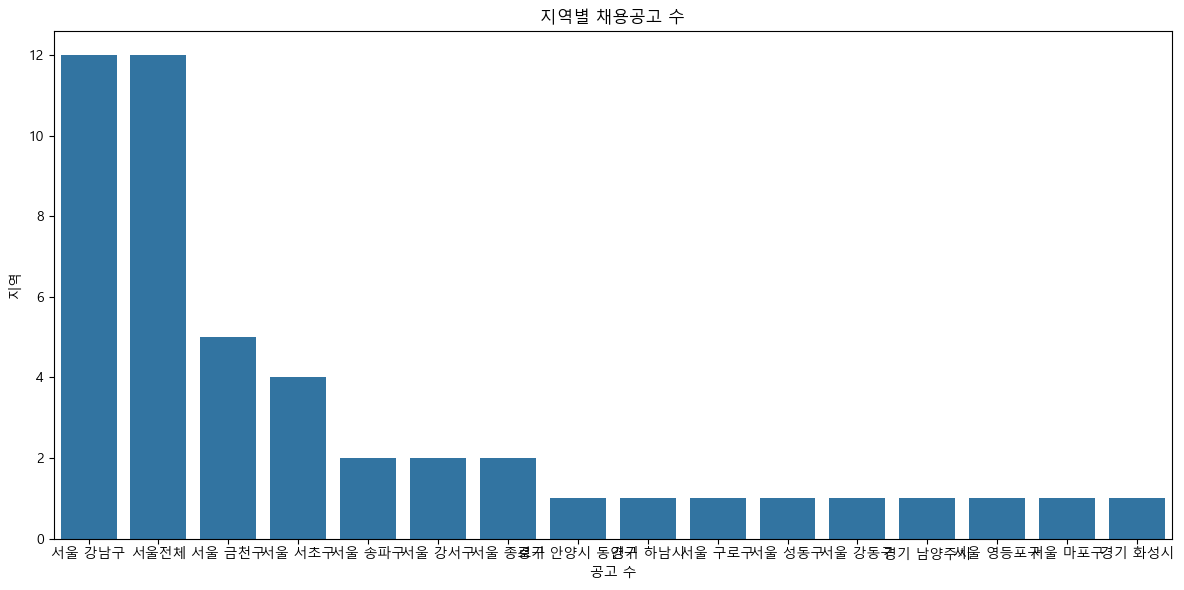

In [12]:

# 지역별 공고 수
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='지역', order=df['지역'].value_counts().index)
plt.title('지역별 채용공고 수')
plt.xlabel('공고 수')
plt.ylabel('지역')
plt.tight_layout()
plt.show()

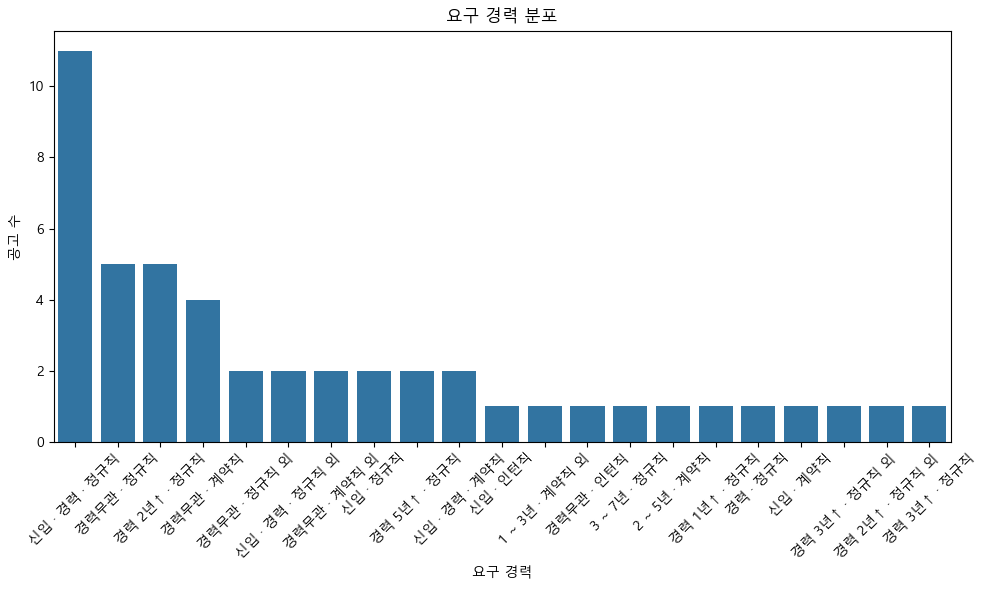

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='요구경력', order=df['요구경력'].value_counts().index)
plt.title('요구 경력 분포')
plt.xlabel('요구 경력')
plt.ylabel('공고 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()